In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer

In [4]:
# from transformers import (
#     AdamW,
#     T5ForConditionalGeneration,
#     T5TokenizerFast as T5Tokenizer
# ) # từ hugging face

from transformers import AutoModel, AutoTokenizer, AdamW

# tqdm: Thư viện cung cấp thanh tiến trình để theo dõi tiến độ của vòng lặp.
from tqdm.auto import tqdm 

# đơn giản hóa và tự động hóa nhiệm vụ như huấn luyện mô hình, quản lý checkpoint, logging, và nhiều công việc khác liên quan đến deep learning.
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint # lưu lại các checkpoint của mô hình trong suốt quá trình huấn luyện
from pytorch_lightning.loggers import TensorBoardLogger # ghi log các thông số quan trọng trong quá trình huấn luyện và theo dõi bằng TensorBoard


import json
import pandas as pd
import numpy as np
import torch
import transformers
from pathlib import Path # làm việc với đường dẫn
from torch.utils.data import Dataset, DataLoader

#from pytorch_lightning.callbacks import ModelCheckpoint
#from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

from random import randint


d:\NLPandDeeplearning\final\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='whitegrid', palette='muted', font_scale = 1.2)
rcParams['figure.figsize'] = 16,10

In [7]:
pl.seed_everything(42)

Seed set to 42


42

In [8]:
read_data = pd.read_csv('../reference/textsummarizationvietnamese1/Dataset_articles_NoID-1.csv', encoding = "utf-8")

In [9]:
data = read_data[["Summary", "Contents"]]
data.columns = ["summary", "text"]

In [10]:
data = data.dropna()
data.tail()

,summary,text
49995,Sau khi “chiến dịch” giành lại vỉa hè ở Hà Nội...,"Xử lý vỉa hè như “ném đá, ao bèo” Ghi nhận của..."
49996,"Do hát karaoke quá to, người đàn ông bị một ng...","Vụ án mạng xảy ra vào khoảng 11h45 ngày 28.2, ..."
49997,"Ngày 28.2, Công an huyện Bố Trạch (tỉnh Quảng ...","Theo đó, cơ quan công an đã ra quyết định khởi..."
49998,"Ngày 28.2, TAND TP.Biên Hòa (Đồng Nai) đã mở p...","Sau khi khai mạc phiên tòa, luật sư bào chữa c..."
49999,"Chỉ vì ghen tuông, Tha đã ném xăng đốt nhà vợ ...","Ngày 28.2, Cơ quan CSĐT Công an tỉnh Trà Vinh ..."


In [11]:
idx = randint(0, data.shape[0])
summary = data['summary'].iloc[idx]
text = data['text'].iloc[idx]
print(f"{idx}:")
print(f"text: {text}")
print(f"summary: {summary}")


41905:
text: Thông tin ban đầu, sáng sớm 16.9, một số người dân đi tập thể dục về phát hiện một nam thanh niên nằm bất động bên ngoài ngôi nhà ở ngõ 30 phố Nghĩa Đô. Theo đó, vào thời gian trên, một nam thanh niên (chưa rõ danh tính) đã dùng một vật nhọn đâm tử vong 2 nữ sinh (chưa rõ danh tính).     2 nữ sinh này đang theo học một trường cao đẳng trên địa bàn quận Cầu Giấy, Hà Nội.  Sau đó, nam thanh niên tự dùng dao đâm vào bụng và nhảy từ tầng cao của ngôi nhà xuống đất, bị thương nặng. Hiện, người này đang được cấp cứu tại Bệnh viện E.      Theo thông tin từ Bệnh viện E, bệnh nhân  nam giới đã tử vong. Hiện lực lượng Công an đang khẩn trương tiến hành khám nghiệm hiện trường, điều tra nguyên nhân vụ án mạng.
summary: Vụ án mạng xảy ra sáng ngày 16.9 tại ngõ 30 phố Nghĩa Đô (quận Cầu Giấy, Hà Nội), khiến 2 nữ sinh tử vong tại chỗ.


# split train - test

In [12]:
train_data, test_data = train_test_split(data, test_size = 0.001)
train_data.shape, test_data.shape

((49321, 2), (50, 2))

In [21]:
class NewsSummaryDataset(Dataset):
	def __init__(
		self,
		data: pd.DataFrame,
		tokenizer: AutoTokenizer,
		text_max_token_len: int = 512,
		summary_max_token_len: int = 128
	):
		self.data = data
		self.tokenizer = tokenizer
		self.text_max_token_len = text_max_token_len
		self.summary_max_token_len = summary_max_token_len
		
	def __len__(self):
		return len(self.data)

	def __getitem__(self, index : int):
		data_row = self.data.iloc[index]
		# xử lí các kí tự \xa0
		data_row["text"] = data_row["text"].replace("\xa0", " ")
		data_row["summary"] = data_row["summary"].replace("\xa0", " ")
		# print(data_row)

		text_encoding = tokenizer(
			data_row["text"],
			max_length = self.text_max_token_len,
			padding = "max_length",
			truncation = True, # cắt nếu độ dài vượt quá padding
			return_attention_mask = True, # tokenizer sẽ tạo ra một tensor biểu diễn attention mask
			add_special_tokens = True, #  tokenizer sẽ thêm các token đặc biệt vào đầu và cuối chuỗi
			return_tensors = "pt" # trả về tensor trong pytorch
		)
  
		summary_encoding = tokenizer(
			data_row["summary"],
			max_length = self.summary_max_token_len,
			padding = "max_length", # padding = 'longest': lấy độ dài dài nhất; "max_length": lấy độ dài theo "max_length"
			truncation = True,
			return_attention_mask = True,
			add_special_tokens = True,
			return_tensors = "pt"
		)
		labels = summary_encoding["input_ids"]
		labels[labels == 0] = -100 # label==0: là những padding thêm vào và gán nó bằng -100

		return dict(
			text = data_row["text"],
			summary = data_row["summary"],
			text_input_ids = text_encoding["input_ids"].flatten(),
			text_attention_mask = text_encoding["attention_mask"].flatten(),
			labels = labels.flatten(),
			labels_attention_mask = summary_encoding["attention_mask"].flatten()
		)

In [22]:
class NewsSummaryDataModule(pl.LightningDataModule):
	def __init__(
		self,
		train_df: pd.DataFrame,
		test_df: pd.DataFrame,
		tokenizer: AutoTokenizer,
		batch_size: int = 8 ,
		text_max_token_len: int =512,
		summary_max_token_len: int = 128
	):
		super().__init__()
		self.train_df = train_df
		self.test_df = test_df

		self.batch_size = batch_size
		self.tokenizer = tokenizer

		self.text_max_token_len = text_max_token_len
		self.summary_max_token_len = summary_max_token_len
	   
	def setup(self, stage = None):
		self.train_dataset = NewsSummaryDataset(
			self.train_df,
			self.tokenizer,
			self.text_max_token_len,
			self.summary_max_token_len
		)
		self.test_dataset = NewsSummaryDataset(
			self.test_df,
			self.tokenizer,
			self.text_max_token_len,
			self.summary_max_token_len
		)
	  
	def train_dataloader(self):
		return DataLoader(
			self.train_dataset,
			batch_size = self.batch_size,
			shuffle = True,
			num_workers = 4 # số luồng CPU
		)
	  
	def val_dataloader(self):
		return DataLoader(
			self.test_dataset,
			batch_size = self.batch_size,
			shuffle = True,
			num_workers = 4  
		)

In [23]:
MODEL_NAME = "vinai/phobert-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# phobert = AutoModel.from_pretrained(MODEL_NAME)

In [80]:
text_token_counts, summary_token_counts = [],[]

for _, row in train_data.iterrows():
    # print(tokenizer.encode(row['text']))
    # break
   
	# print(row['text'])
	text_token_count = len(tokenizer.encode(row["text"]))
	text_token_counts.append(text_token_count)

	summary_token_count = len(tokenizer.encode(row["summary"]))
	summary_token_counts.append(summary_token_count)

Text(0.5, 1.0, 'summary text token counts')

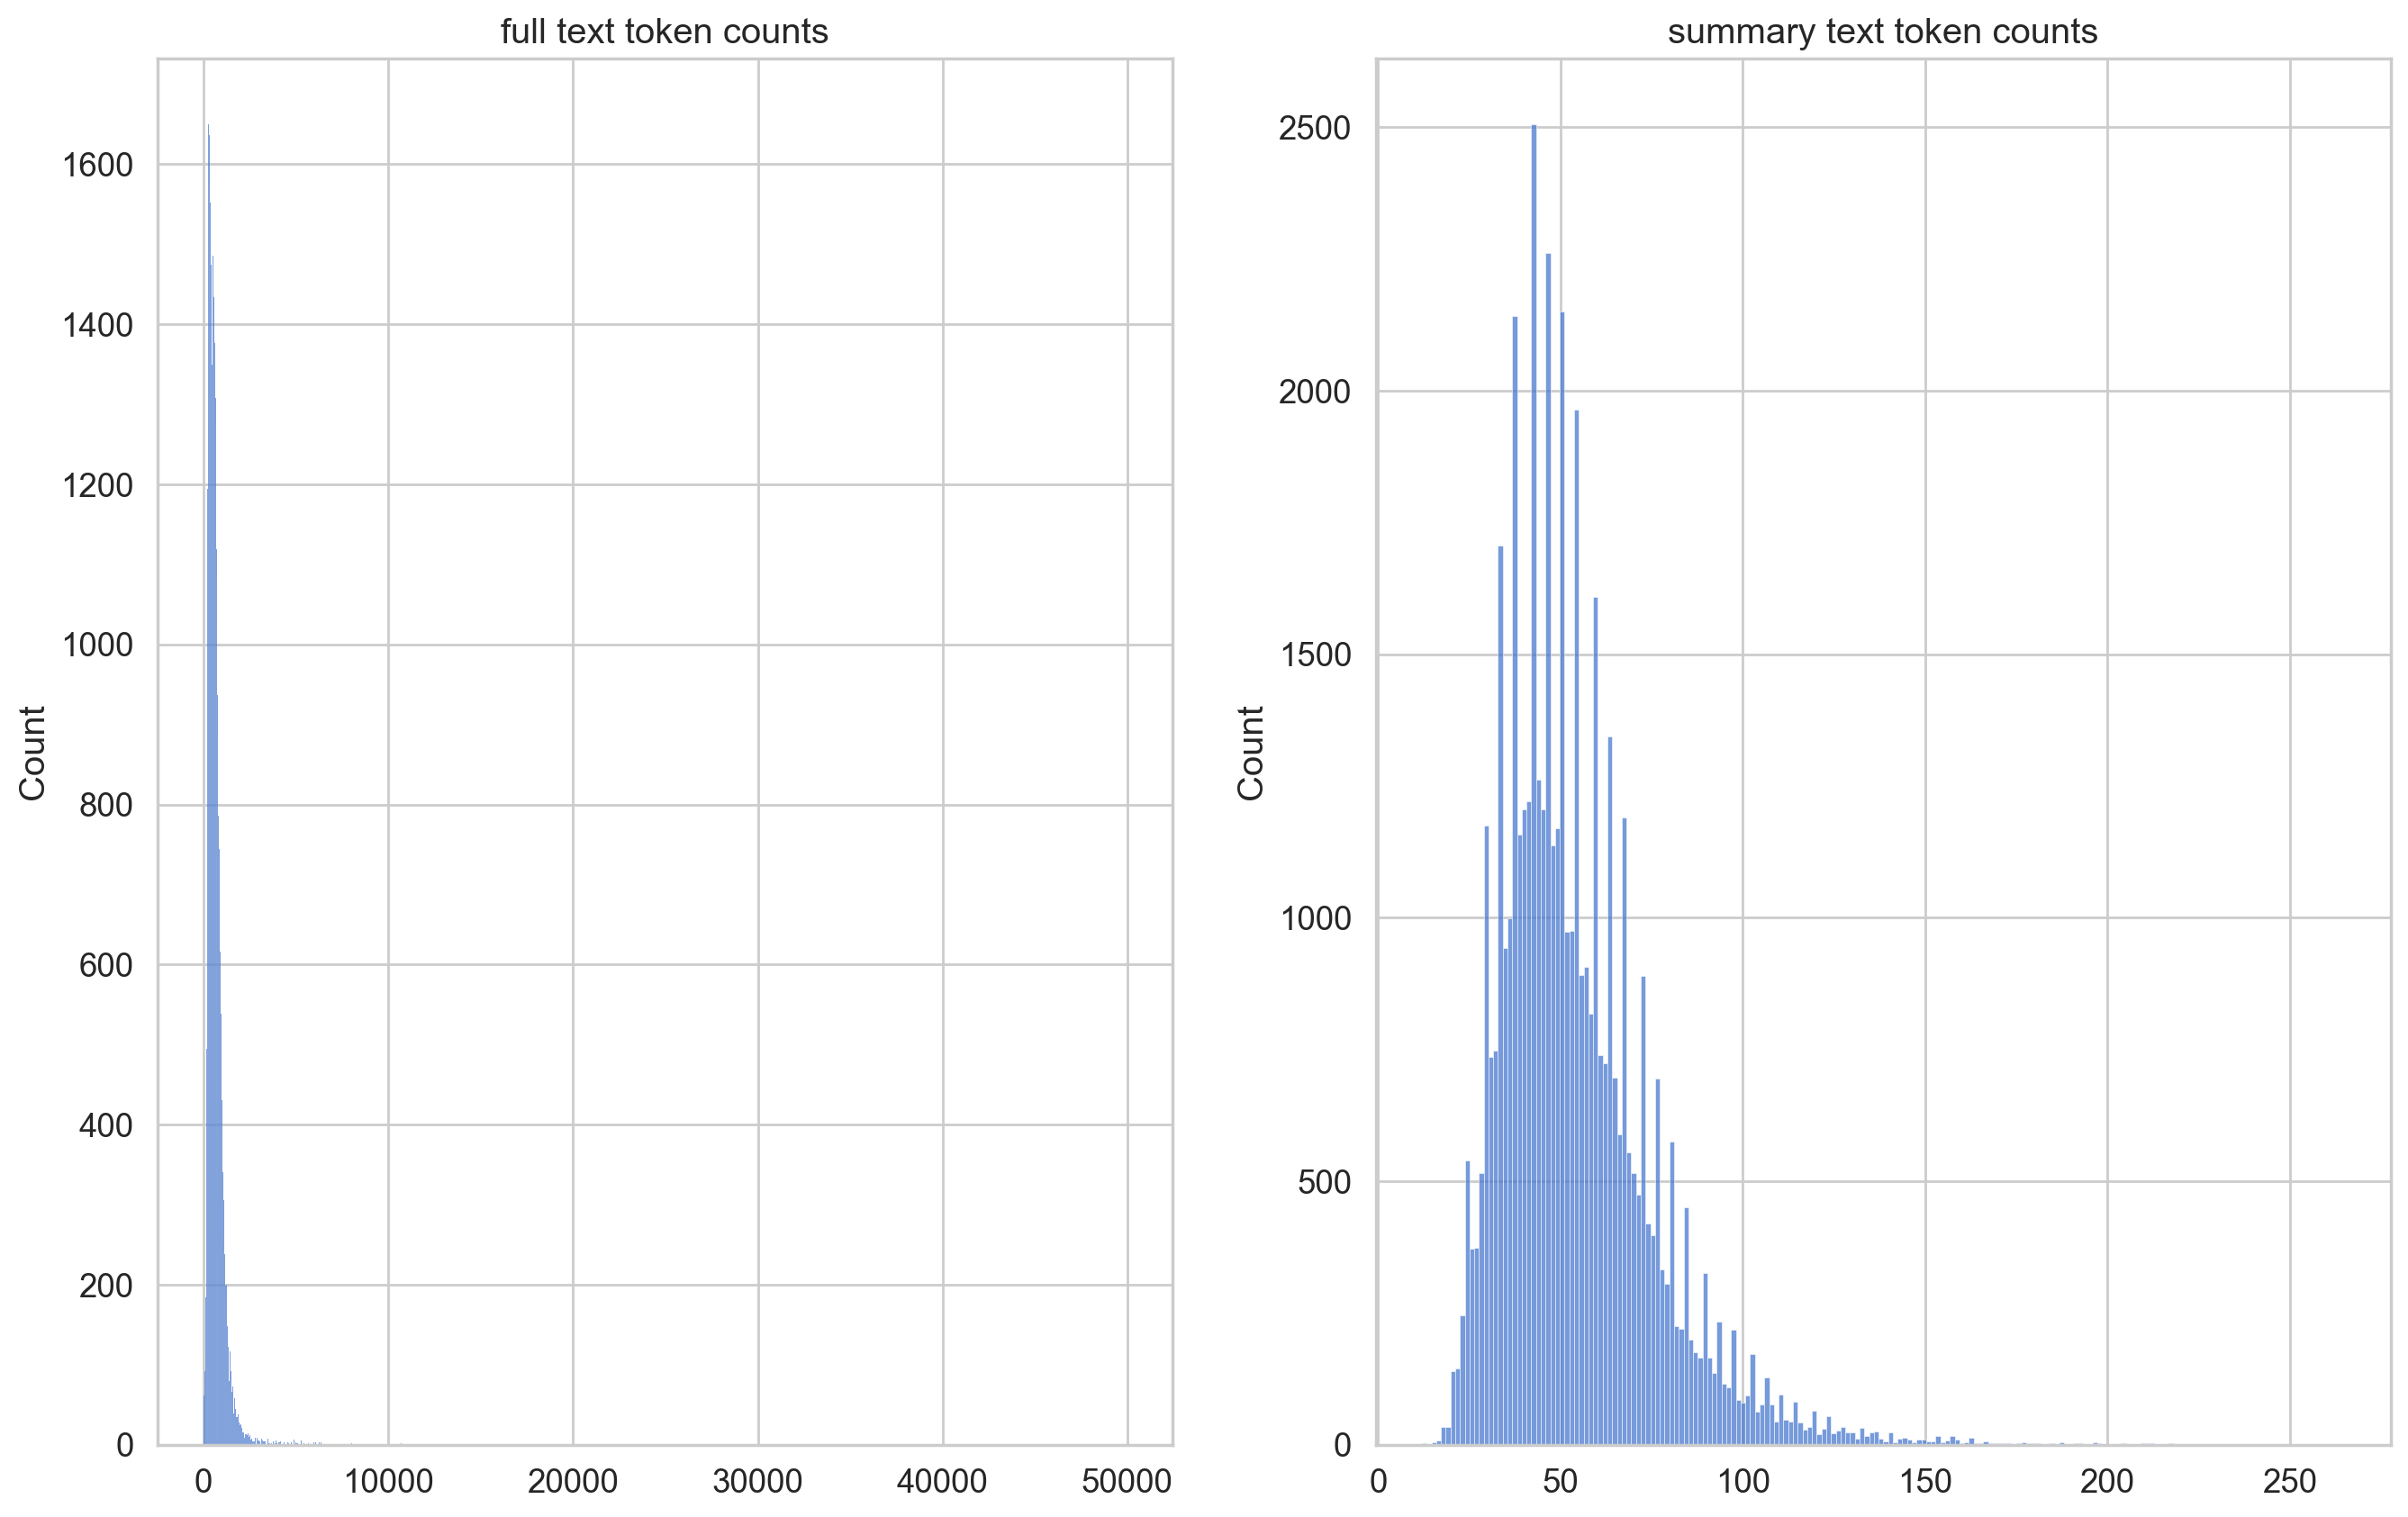

In [81]:
fig, (ax1, ax2) = plt.subplots(1,2)

sns.histplot(text_token_counts, ax = ax1)
ax1.set_title("full text token counts")

sns.histplot(summary_token_counts, ax= ax2)
ax2.set_title("summary text token counts")

In [24]:
num_epochs = 3
BATCH_SIZE = 8

data_module = NewsSummaryDataModule(train_data, test_data, tokenizer, batch_size = BATCH_SIZE)

In [25]:
class NewsSummaryModel(pl.LightningModule):
	def __init__(self):
		super().__init__()
		self.model =  AutoModel.from_pretrained(MODEL_NAME, return_dict = True)
		
	def forward(self, input_ids, attention_mask, decoder_attention_mask, labels = None):
		output = self.model(
			input_ids,
			attention_mask = attention_mask,
			labels = labels,
			decoder_attention_mask = decoder_attention_mask
		)

		return output.loss, output.logits

	def training_step(self, batch, batch_idx):
		input_ids = batch["text_input_ids"]
		attention_mask = batch["text_attention_mask"]
		labels = batch["labels"]
		labels_attention_mask = batch["labels_attention_mask"]

		loss, outputs = self(
			input_ids = input_ids,
			attention_mask = attention_mask,
			decoder_attention_mask = labels_attention_mask,
			labels = labels   
		)
		self.log("train_loss", loss, prog_bar = True, logger = True)
		return loss 
   
	def validation_step(self, batch, batch_idx):
		input_ids = batch["text_input_ids"]
		attention_mask = batch["text_attention_mask"]
		labels = batch["labels"]
		labels_attention_mask = batch["labels_attention_mask"]

		loss, outputs = self( 
			input_ids = input_ids,
			attention_mask = attention_mask,
			decoder_attention_mask = labels_attention_mask,
			labels = labels
		)  
		self.log("val_loss", loss, prog_bar = True, logger = True)
		return loss 

	def test_step(self, batch, batch_idx): 
		input_ids = batch["text_input_ids"]
		attention_mask = batch["text_attention_mask"]
		labels = batch["labels"] 
		labels_attention_mask = batch["labels_attention_mask"] 

		loss, outputs = self( 
			input_ids = input_ids,
			attention_mask = attention_mask,
			decoder_attention_mask = labels_attention_mask,
			labels = labels
		)

		self.log("test_loss", loss, prog_bar = True, logger = True) 
		return loss 

	def configure_optimizers(self):
		return AdamW(self.parameters(), lr = 0.0001)

In [26]:
model = NewsSummaryModel()


In [27]:
trainer = pl.Trainer()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
trainer.fit(model, data_module)

d:\NLPandDeeplearning\final\.venv\lib\site-packages\pytorch_lightning\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\NLPandDeeplearning\final\.venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type         | Params
---------------------------------------
0 | model | RobertaModel | 134 M 
---------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
539.993   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\NLPandDeeplearning\final\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
d:\NLPandDeeplearning\final\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


In [88]:
model

NewsSummaryModel(
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

In [89]:
checkpoint_callback = ModelCheckpoint(
        dirpath ="checkpoints",
        filename = "best-checkpoint",
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )
logger = TensorBoardLogger("lightning_logs", name = "news-summary")

In [90]:
trainer = pl.Trainer(
    logger = logger,
    callbacks = checkpoint_callback,
    max_epochs = num_epochs
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [91]:
trainer.fit(model, data_module)


Missing logger folder: lightning_logs\news-summary
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\NLPandDeeplearning\final\.venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type         | Params
---------------------------------------
0 | model | RobertaModel | 134 M 
---------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
539.993   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\NLPandDeeplearning\final\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
d:\NLPandDeeplearning\final\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


In [3]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers):
        super(TransformerEncoder).__init__()
        self.embedding = nn.Embedding(input_dim, d_model)
        self.transformer_encoder = TransformerDecoder(
            TransformerDecoderLayer(d_model, nhead),
            num_layers
        )
    
    def forward(self, src):
        src = self.embedding(src)
        output = self.transformer_encoder(src)
        return output
    
class TransformerDecoder(nn.Module):
    def __init__(self, output_dim, d_model, nhead, num_layers):
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, d_model)
        self.transformer_decoder = TransformerDecoder(
            TransformerDecoderLayer(d_model, nhead),
            num_layers
        )

    def forward(self, tgt, memory):
        tgt = self.embedding(tgt)
        output = self.transformer_decoder(tgt, memory)
        return output
